<a href="https://colab.research.google.com/github/lbk209/topic_modeling/blob/main/tm_develop_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
%%capture
!pip install bertopic

In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import tqdm
import datetime

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 5000)

import plotly.io as pio
pio.templates.default = 'simple_white'
from bertopic import BERTopic

# Data

In [3]:
path_src = '/content/drive/MyDrive/Colab\ Notebooks'
path_data = 'sample_data'

In [28]:
file = 'hotel_reviews_with_transl'
!unzip -n {path_src}/{file}.zip -d {path_data}

Archive:  /content/drive/MyDrive/Colab Notebooks/hotel_reviews_with_transl.zip


In [35]:
f = f'{path_data}/{file}.csv'
df_data = pd.read_csv(f, sep = '\t')

In [36]:
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Travelodge,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",en,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",981


In [ ]:
df_data.review.count()

In [37]:
# testing
df_data = df_data.sample(frac=.2)
df_data = df_data.drop('id', axis=1).reset_index(drop=True).rename_axis('id').reset_index()
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Millemiun,"Ok choice if you can get a deal. My husband and I booked this hotel through Priceline for £50! Once finding out that we were to stay at the Millenium Gloucester and finding the reviews on this website, we were rather nervous about our stay!The lobby/reception area is truly gigantic and well maintained. The staff were efficient and polite and didn't look down their noses at us because we'd evidently booked through Priceline (this did happen once before at another hotel in London!).Our room wasn't one of the newly renovated rooms, but it was clean. It took us a while to find out how the individual lamps worked as the &quot;main&quot; light in the entrance to the room only lit up that bit. Luckily, we weren't electocuted as one person suggested we might be!The room was close to the lift area, but we heard very little noise/movement. The road outside also seemed to be quite quiet on the Sunday morning.The bathroom is definitely very very tired, but again, it was clean with decent sized and a decent amount of towels. Make sure you use the slip-mat that is provided - you need it!We didn't have breakfast in the hotel as it was £17.50 per person! Instead, there is a Coffee Republic at the top of the street. There are also a few more cafes closer to the Gloucester Road tube station which also seemed to be serving breakfast.All in all, we had a pleasant stay, but I feel sorry for anyone who pays the full price for the room that we had. The room that we stayed in was one of a tired 3 star standard. However, the position of the hotel was fantastic being in a quiet area, very close to a tube station.",en,"Ok choice if you can get a deal. My husband and I booked this hotel through Priceline for £50! Once finding out that we were to stay at the Millenium Gloucester and finding the reviews on this website, we were rather nervous about our stay!The lobby/reception area is truly gigantic and well maintained. The staff were efficient and polite and didn't look down their noses at us because we'd evidently booked through Priceline (this did happen once before at another hotel in London!).Our room wasn't one of the newly renovated rooms, but it was clean. It took us a while to find out how the individual lamps worked as the &quot;main&quot; light in the entrance to the room only lit up that bit. Luckily, we weren't electocuted as one person suggested we might be!The room was close to the lift area, but we heard very little noise/movement. The road outside also seemed to be quite quiet on the Sunday morning.The bathroom is definitely very very tired, but again, it was clean with decent sized and a decent amount of towels. Make sure you use the slip-mat that is provided - you need it!We didn't have breakfast in the hotel as it was £17.50 per person! Instead, there is a Coffee Republic at the top of the street. There are also a few more cafes closer to the Gloucester Road tube station which also seemed to be serving breakfast.All in all, we had a pleasant stay, but I feel sorry for anyone who pays the full price for the room that we had. The room that we stayed in was one of a tired 3 star standard. However, the position of the hotel was fantastic being in a quiet area, very close to a tube station.",1614


In [38]:
df_data.review.count()

2459

In [39]:
docs = df_data.reviews_transl.tolist()
classes_all = df_data.hotel.tolist()

# 🗨️ **BERTopic**

In [12]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2
}

vectorizer_model = CountVectorizer(
    min_df=5,
    stop_words = 'english')
topic_model = BERTopic(
    min_topic_size = 5, # default 10
    nr_topics = 'auto',
    vectorizer_model = vectorizer_model,
    representation_model = representation_model)
topics, ini_probs = topic_model.fit_transform(docs)

In [42]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

31

In [43]:
get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(7).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
-1,1072,43.59,43.59,-1_hotel_hotels_london_rooms,"[hotel, hotels, london, rooms, room, hilton, booked, place, restaurant, reception]","[hotel, room, good, staff, breakfast, location, stay, night, rooms, great]","[hotels, london, room, booked, restaurant, reception, bus, reviews, bar, stayed]"
0,990,40.26,83.86,0_hotel_hotels_rooms_london,"[hotel, hotels, rooms, london, room, inn, spacious, hilton, heathrow, bathroom]","[hotel, room, london, great, location, good, stay, breakfast, clean, staff]","[hotels, rooms, heathrow, bathroom, place, booked, gloucester, victoria, reception, central]"
1,30,1.22,85.08,1_hotel_euston_rooms_hilton,"[hotel, euston, rooms, hilton, london, cafe, station, room, reception, travelodge]","[station, hotel, minutes, nice, good, breakfast, room, size, staff, rooms]","[hotel, euston, rooms, london, cafe, station, bathroom, reviews, st, store]"
2,25,1.02,86.09,2_hilton_hotel_hotels_lounge,"[hilton, hotel, hotels, lounge, room, queue, queues, booked, pool, staying]","[hilton, executive, room, lounge, staff, line, standards, hotel, floor, pool]","[hotels, queue, pool, station, paddington, drinks, fridge, clerk, points, minutes]"
3,25,1.02,87.11,3_hotel_hotels_london_rooms,"[hotel, hotels, london, rooms, inn, booking, bloomsbury, covent, booked, room]","[hotel, good, breakfast, nice, clean, great, room, trip, location, staff]","[hotels, london, bloomsbury, booked, room, bath, theatre, recommend, museum, holborn]"
4,19,0.77,87.88,4_rooms_hotel_london_room,"[rooms, hotel, london, room, furnished, gloucester, tours, kensington, concierge, fixtures]","[road, location, street, room, grocery, desk, helpful, hotel, lines, station]","[rooms, hotel, london, furnished, tours, bath, restaurants, definitely, carpets, station]"
5,19,0.77,88.65,5_hotel_booking_rooms_facilities,"[hotel, booking, rooms, facilities, booked, london, concert, room, station, park]","[concert, hotel, stay, bathroom, lovely, basic, walk, facilities, station, clean]","[hotel, facilities, london, concert, station, park, taxi, access, shuttle, dlr]"


In [44]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [45]:
topic_model.visualize_topics()

In [46]:
df_data['basic_topic'] = topics

# Topic distribution

In [51]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4,
                                                                      calculate_tokens=True)

In [ ]:
topic_distr.shape

(6148, 48)

In [ ]:
topic_distr

array([[0.06371714, 0.06873226, 0.0132352 , ..., 0.00121798, 0.005349  ,
        0.03482469],
       [0.05241437, 0.04816061, 0.0202135 , ..., 0.06517852, 0.01004273,
        0.01279541],
       [0.05224263, 0.0837024 , 0.01374098, ..., 0.        , 0.00382569,
        0.04156356],
       ...,
       [0.05090641, 0.04772442, 0.01767312, ..., 0.        , 0.        ,
        0.06165296],
       [0.04443437, 0.05440567, 0.02188142, ..., 0.00669112, 0.00992321,
        0.01245146],
       [0.05238923, 0.05312501, 0.09075179, ..., 0.00346122, 0.00794154,
        0.00982997]])

Text(0.5, 1.0, 'Distribution of topic non-zero probabilities')

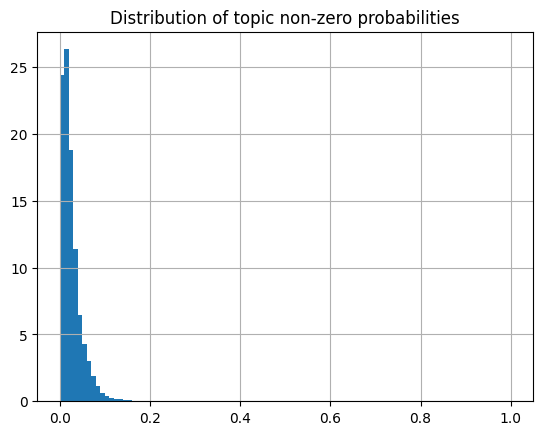

In [ ]:
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
ax.set_title('Distribution of topic non-zero probabilities')

In [ ]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [ ]:
 df_data[df_data.max_topic_distr > 0.05].shape

(6104, 7)

In [ ]:
1 - df_data[df_data.max_topic_distr > 0.05].shape[0]/df_data.shape[0]

0.0071567989590111125

In [ ]:
df_data.head(3)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
0,Hilton,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not restricted by room key cards and the street emergency exits did not close either behind me during the evacuation. However, I would stay again, rather have one fake alarm too many than a real fire. During the evacuation I noticed that my room did not have a safety exit map posted on the room's door.",en,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not res

In [ ]:
df_data[(df_data.max_topic_distr > 0.1) & (df_data.reviews_len >= 100)].sample(10)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
6117,Radisson,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,en,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,501,-1,0.17
999,Park Plaza,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",en,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",351,0,0.12
3576,Hilton,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",en,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",474,0,0.14
1805,Holiday Inn,Ideal hotel for location and value for money. Stayed here with my ten year old daughter for 2 nights In Ausgust. I wanted somewhere in a safe location since I was a femaile on her own with a child and also not too far from all the attractions . Paid £119 for 2 nights through my empolyer's staff discount website which I thought was excellent value for London In Ausgust. The hotel was easy to find- you can either use West Kensington or West Brompton Tube Stations. I do like Holiday Inn Express hotels as they are good value and provide me with what I want from a hotel- somewhere clean to rest my head and a good shower. The breakfasts are also a bonus though I must admitt the choice at thisone wasn't as good as the Dunfermline Hol Inn Express I had stayed in the week before but we didn't leave hungry! Staff were friendly and we didn't have any problems wuth our personal belongings. Our room was serviced whilst we were out and everything was still there when we got back. There is air con as the windows don't open and we did find ourselves switching it on and off as one minute we were hot and the next cold There is a few restuarants nearby and a T

In [ ]:
doc_id = 6117
min_probability = 0.05
a = topic_model.visualize_distribution(topic_distr[doc_id], min_probability=min_probability)
a

In [ ]:
import re

pattern = r'<b>\s*Topic\s*(\d+)</b>'
tid_list = []

for s in a.data[0]['y']:
    # Search for the pattern
    match = re.search(pattern, s, re.IGNORECASE)
    tid_list.append(int(match.group(1)))

tid_list

[0, 21, 25, 30, 34]

In [ ]:
# Visualize the token-level distributions
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,Above,average,for,London,just,recently,stayed,at,the,Portman,Square,and,it,was,nice,The,price,was,average,especially,when,prices,are,outrageous,now,The,roomsize,was,small,but,mean,you,can,expect,much,in,London,honestly,Rooms,are,always,going,to,be,small,and,these,were,decent,size,The,bathrooms,were,the,best,part,because,there,were,American,Standard,bathrooms,There,is,great,shopping,two,blocks,down,on,Oxford,Street,but,you,must,eat,drink,early,because,that,area,closes,by,10pm,Cheerio
0_hotel_hotels_rooms_paddington,0.000,0.111,0.111,0.236,0.236,0.125,0.231,0.106,0.106,0.106,0.000,0.111,0.221,0.354,0.488,0.377,0.267,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_hotel_hotels_rooms_booking,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_hotel_hotels_hilton_hiltons,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.213,0.213,0.213,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_radisson_radissons_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.241,0.362,0.482,0.362,0.241,0.121,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_gloucester_hotels_hotel_london,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.210,0.313,0.417,0.312,0.207,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_mayfair_london_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.212,0.318,0.318,0.212,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_worth_value_hotel_cheap,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.231,0.231,0.231,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [ ]:
docs[doc_id]

"Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!"

In [ ]:
a = vis_df.data.to_dict('index')
ak = list(a.keys())
ak

['0_hotel_hotels_rooms_paddington',
 '1_hotel_hotels_rooms_booking',
 '2_hotel_hotels_hilton_hiltons',
 '3_radisson_radissons_hotel_hotels',
 '4_gloucester_hotels_hotel_london',
 '5_mayfair_london_hotel_hotels',
 '6_worth_value_hotel_cheap',
 '7_hotel_hotels_rooms_euston',
 '15_pleasantly_experience_excellent_disappointing',
 '16_hotel_baileys_rooms_room',
 '17_hotel_olympia_london_hilton',
 '18_hotel_rooms_room_oxford',
 '19_hilton_hiltons_hotel_hotels',
 '21_rooms_bedroom_hotels_hotel',
 '22_accommodation_london_hotel_heathrow',
 '23_hotel_hotels_rooms_london',
 '25_hotels_hotel_leicester_rooms',
 '27_location_nearby_located_place',
 '30_london_worth_value_affordable',
 '32_hotel_marriott_touristy_hilton',
 '34_hotels_hotel_london_rooms',
 '47_rooms_hotel_staff_room']

In [ ]:
#[k.strip() for k,v in a[ak[0]].items() if v > 0.2]
ts_dict = {}
blocks = []
block = []

tp = ak[0]
th = 0.1

for k,v in a[tp].items():
    if v > th:
        block.append(k.strip())
    else:
        if len(block) > 0:
            blocks.append(' '.join(block))
        block = []

ts_dict[tp] = blocks

In [ ]:
ts_dict

{'0_hotel_hotels_rooms_paddington': ['average for London just recently stayed at the Portman',
  'and it was nice The price was']}

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
sentiment_pipeline(list(ts_dict.values())[0])

[{'label': 'NEGATIVE', 'score': 0.998954176902771},
 {'label': 'NEGATIVE', 'score': 0.9973662495613098},
 {'label': 'NEGATIVE', 'score': 0.9972761273384094},
 {'label': 'POSITIVE', 'score': 0.997960090637207}]

In [ ]:
list(ts_dict.values())[0]

['business Would not stay again Clean but not really clean champagne cork found',
 'gel no hairdryer Location good situated in central',
 'dark Carpet looked little unsavoury needed god',
 'vacuum Receptionist very pleasant moved me with']

In [ ]:
ts_dict

{'0_pleasant_location_cheap_away': ['business Would not stay again Clean but not really clean champagne cork found',
  'gel no hairdryer Location good situated in central',
  'dark Carpet looked little unsavoury needed god',
  'vacuum Receptionist very pleasant moved me with']}

In [ ]:
from transformers import pipeline

def get_subsentences(vis_df, min_dist=0.1):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        for token, dist in dist_dict.items():
            if dist > min_dist:
                block.append(token.strip())
            else:
                if len(block) > 0:
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topci_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_anlysis(subs)
        scores = []
        for x in res:
            s = x['score']
            if x['label'] == 'NEGATIVE':
                s = -s
            scores.append(s)
        senti[topic] = scores
    return senti


# distilbert/distilbert-base-uncased-finetuned-sst-2-english
# see https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# no neutral?
sentiment_pipeline = pipeline("sentiment-analysis")

#doc_id = 11389
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

subs = get_subsentences(vis_df, min_dist=0.1)
senti = topci_sentiment(subs, sentiment_pipeline)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


i = 0
get_topic_score(i, subs, senti)


0_hotel_hotels_rooms_paddington:
average for London just recently stayed at the Portman: -0.9104356169700623
and it was nice The price was: 0.9996762275695801


## Topic Sentiment

In [ ]:
import re


def get_topics_from_proba(topic_model,
                          topic_distr_doc,
                          min_probability=0.1,
                          pattern = r'<b>\s*Topic\s*(\d+)</b>'):
    """
    get the topics of a document from the distribution of topic probabilities
    """
    probs = topic_model.visualize_distribution(topic_distr_doc, min_probability=min_probability)

    tid_list = []

    for s in probs.data[0]['y']:
        # Search for the pattern
        match = re.search(pattern, s, re.IGNORECASE)
        tid_list.append(int(match.group(1)))

    return tid_list


def get_subsentences(vis_df, min_dist=0.1, tids=None, n_padding=0):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        if int(topic.split('_')[0]) not in tids:
            continue

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        token_all = list(dist_dict.keys())
        for i, (token, dist) in enumerate(dist_dict.items()):
            if dist > min_dist:
                if (i * n_padding > 0) and (len(block) == 0):
                    start = max(i-n_padding, 0)
                    block = [x.strip() for x in token_all[start:i]]
                block.append(token.strip())
            else:
                if len(block) > 0:
                    if n_padding > 0:
                        block.extend([x.strip() for x in token_all[i:i+n_padding]])
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topic_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_anlysis(subs,
                                # return max score only
                                return_all_scores=False)
        scores = []
        for x in res:
            #s = x['score']
            #if x['label'] == 'NEGATIVE':
            #    s = -s
            s = f'({x["label"]}) {x["score"]:.3f}'
            scores.append(s)
        senti[topic] = scores
    return senti


def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


def get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                        sentiment_anlysis,
                        min_probability = 0.1, pattern = r'<b>\s*Topic\s*(\d+)</b>',
                        min_dist = 0.1,
                        single_subsentence=False,
                        n_padding = 0
                        ):

    tids = get_topics_from_proba(topic_model, topic_distr_doc,
                                 min_probability=min_probability,
                                 pattern=pattern)

    vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)
    subs = get_subsentences(vis_df, min_dist=min_dist, tids=tids, n_padding=n_padding)

    #return subs # testing
    if single_subsentence:
        subs = {k: ['. '.join(v)] for k,v in subs.items()}

    senti = topic_sentiment(subs, sentiment_anlysis)

    for i in range(len(subs)):
        get_topic_score(i, subs, senti)
        print()




In [ ]:
from transformers import pipeline

# check more models: https://huggingface.co/models?other=sentiment-analysis
#model_id = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
#model_id = 'siebert/sentiment-roberta-large-english'
model_id = 'MarieAngeA13/Sentiment-Analysis-BERT'

sentiment_pipeline = pipeline("sentiment-analysis",
                              model=model_id,
                              #return_all_scores=True
                              )

In [ ]:
# testing: best result with MarieAngeA13/Sentiment-Analysis-BERT
sentiment_pipeline(['Stayed here for nights'],
                   return_all_scores=False
                   )

[{'label': 'neutral', 'score': 0.9558405876159668}]

In [ ]:
#df_data.head()

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True
                                                                      #window = 4, stride=1 # default
                                                                      #window = 8, stride=4, # error
                                                                      #window = 8, stride=1,
                                                                      #window = 8, stride=2,
                                                                      #min_similarity = 0.1 # default
                                                                      #use_embedding_model = True
                                                                      )

In [ ]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [ ]:
cond = (df_data.max_topic_distr > 0.1)
#cond = cond & (df_data.reviews_len >= 100)
df_data[cond].sample(5)

,hotel,review,lang,reviews_transl,reviews_len,max_topic_distr
859,Travelodge,"Would not return. Stayed here for 2 nights in April on business. Would not stay again. Clean but not really clean - champagne cork found behind the sofa in the corner of the room, couple of short black hairs in my bed although linen looked pressed and unslept in. Very basic - no shampoo, no shower gel, no hairdryer. Location good - situated in central London but down the dodgy, shadowy, dark end of Drury Lane. Speaking from a female persepctive - would not have felt safe outside after dark. Carpet looked a little unsavoury - needed a god shampoo and vacuum! Receptionist very pleasant - moved me with no fuss from hideous underground room with view of old matresses stacked up in underground car park to first floor. Only plus is plasma screen TV in room - the only luxury. I know it is cheap but it wasn't very cheerful. Definitely would not recommend. Needs modernising and a good lick of paint.",en,"Would not return. Stayed here for 2 nights in April on business. Would not stay again. Clean but not really clean - champagne cork found behind the sofa in the corner of the room, couple of short black hairs in my bed although linen looked pressed and unslept in. Very basic - no shampoo, no shower gel, no hairdryer. Location good - situated in central London but down the dodgy, shadowy, dark end of Drury Lane. Speaking from a female persepctive - would not have felt safe outside after dark. Carpet looked a little unsavoury - needed a god shampoo and vacuum! Receptionist very pleasant - moved me with no fuss from hideous underground room with view of old matresses stacked up in underground car park to first floor. Only plus is plasma screen TV in room - the only luxury. I know it is cheap but it wasn't very cheerful. Definitely would not recommend. Needs modernising and a good lick of paint.",903,0.12
1115,Park Inn,"Wish it still was the Gresham - Park Inn Management needs improvement. We have stayed at this hotel 3 times when it was the Gresham because we got a very good room rate through the airline. The first time we stayed there was when the Gresham chain took over and the breakfast service staff seemed confused and service was extremely slow. We returned in spite of the breakfast service as it is convenient to the tube, buses and Hyde Park. The service improved and we settled in.We booked this hotel again through the airline and it was the most expensive room we had on a two week trip to Europe. We were terribly disappointed. The room we were given initially was a twin room with literally no room for suitcases  we had to sit them in front of the door and stand them upright and move them between the beds when we wanted to go out. We asked for a bigger room and told we could not get one until the next morning, which was fine. They moved the luggage for us, but they moved it to a smoking room, which the desk insisted I had requested. I apologized and said I mustn't have said non-smoking loud enough, and we moved our own luggage to a new room. None of the rooms had mini bars like the rooms we had stayed in on our previous stays. The best feature of this hotel was the bath/shower facilities. They have a bathtub, a hand held shower and an overhead shower and we always look forward to this luxury. This time it was marred by the state of the tile in the bathroom. The tile and tub corners were completely covered in mold and mildew. It was disgusting. I am posting pictures of this with the review so you can decide if you want to pay for this.There are plenty of hotels in this Lancaster Gate area and we will choose another one next time. The breakfast service is again chaos and there is a long wait for seating even when there are hardly any other customers. There is also poor service at breakfast for your coffee or tea.",en,"Wish it still was the Gresham - Park Inn Management needs improvement. We have stayed at this hotel 3 times when it was the Gresham because we

In [ ]:
doc_id = 859
min_probability = 0.05

topic_model.visualize_distribution(topic_distr[doc_id], min_probability=min_probability)

In [ ]:
i = doc_id
#min_probability = 0.1
min_dist = 0.0

doc = docs[i]
topic_distr_doc = topic_distr[i]
topic_token_distr_doc = topic_token_distr[i]

get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                    sentiment_pipeline,
                    min_probability = min_probability, min_dist = 0.0,
                    single_subsentence=False,
                    #n_padding = 1
                    )

0_hotel_hotels_london_rooms:
Stayed here for nights: (neutral) 0.956
business Would not stay again Clean but not really clean champagne cork found: (negative) 0.683
Location good situated in central London but down the: (positive) 0.586
park to first floor: (neutral) 0.970
in room the only: (neutral) 0.949

2_hotel_restaurant_rooms_bedroom:
Stayed here for nights: (neutral) 0.956
Would not stay again Clean but not really clean champagne cork found: (negative) 0.632
in room the only: (neutral) 0.949
Definitely would not recommend: (negative) 0.751

8_value_money_expensive_cheap:
not stay again Clean but not: (neutral) 0.821
clean champagne cork found: (neutral) 0.872

9_hotel_hotels_rooms_room:
Stayed here for nights: (neutral) 0.956
Would not stay again Clean but not really clean champagne cork: (negative) 0.565
London but down the: (neutral) 0.964
in room the only: (neutral) 0.949
Definitely would not recommend: (negative) 0.751

19_covent_hotel_london_rooms:
Stayed here for nights: (

In [ ]:
get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                    sentiment_pipeline,
                    min_probability = min_probability, min_dist = 0.0,
                    single_subsentence=False,
                    n_padding = 1)

0_hotel_hotels_london_rooms:
return Stayed here for nights in: (neutral) 0.960
on business Would not stay again Clean but not really clean champagne cork found behind: (negative) 0.603
hairdryer Location good situated in central London but down the dodgy: (neutral) 0.465
car park to first floor Only: (neutral) 0.964
TV in room the only luxury: (neutral) 0.734

2_hotel_restaurant_rooms_bedroom:
return Stayed here for nights in: (neutral) 0.960
business Would not stay again Clean but not really clean champagne cork found behind: (negative) 0.703
TV in room the only luxury: (neutral) 0.734
cheerful Definitely would not recommend Needs: (negative) 0.421

8_value_money_expensive_cheap:
Would not stay again Clean but not really: (neutral) 0.617
really clean champagne cork found behind: (positive) 0.686

9_hotel_hotels_rooms_room:
return Stayed here for nights in: (neutral) 0.960
business Would not stay again Clean but not really clean champagne cork found: (negative) 0.683
central London but

In [ ]:
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

## filter irrelevant topics with too low probability

In [ ]:
import tqdm

tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1

    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')

    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr

    tmp_dfs.append(tmp_df_aggr)

100%|██████████| 150/150 [00:08<00:00, 18.38it/s]


In [ ]:
num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

In [ ]:
num_topics_stats_df

num_topics_group,0,1,2,3,4,5+
threshold,,,,,,
0.00,0.00,0.00,0.00,0.00,0.00,100.00
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
...,...,...,...,...,...,...
0.14,79.83,16.35,2.77,0.65,0.20,0.20
0.15,80.48,15.86,2.68,0.61,0.16,0.20
0.15,80.89,15.53,2.60,0.61,0.16,0.20


In [ ]:
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [ ]:
import plotly.express as px

colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df,
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      },
        width = 800
       )

### visualize_topic_distr_per_threshold

In [58]:
def visualize_topic_distr_per_threshold(topic_distr, max_threshhold=0.15, n_topics=5,
                                        colormap = px.colors.sequential.YlGnBu,
                                        vl_max_share = 0.1, vl_decr=0.01,
                                        width = 800):
    """
    calculate the distribution of selected topics per review for different threshold levels
    n_topics: 1~8
    """
    tmp_dfs = []

    for thr in tqdm.tqdm(np.arange(0, max_threshhold, 0.001)):
        tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
            columns = {0: 'num_topics'}
        )
        tmp_df['num_docs'] = 1

        tmp_df['num_topics_group'] = tmp_df['num_topics']\
            .map(lambda x: str(x) if x < n_topics else f'{n_topics}+')

        tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
        tmp_df_aggr['threshold'] = thr

        tmp_dfs.append(tmp_df_aggr)

    num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

    num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

    n_cm = len(colormap)
    n_tps = num_topics_stats_df.columns
    idx = np.random.choice(range(1, n_cm-1), len(n_tps)-2, replace=False)
    idx = [0, *idx, n_cm-1]
    cdm = {k: colormap[i] for k, i in zip(n_tps, np.sort(idx))}

    fig = px.area(num_topics_stats_df,
        title = 'Distribution of number of topics',
        labels = {'num_topics_group': 'number of topics',
                    'value': 'share of reviews, %'},
        color_discrete_map = cdm,
        width = width
        )

    # plot vline of optimized threshold
    x = search_min_theshold(num_topics_stats_df, max_share=vl_max_share, decr=vl_decr)
    if isinstance(x, list):
        x = sum(x)/len(x)

    if x is not None:
        fig.add_vline(x=0.08, line_width=1, line_dash="dash",
                    #line_color="green"
                    )

    return fig


def search_min_theshold(num_topics_stats_df, max_share = 0.1, decr=0.01):
    """
    search threshold to minimize the shares of 0 topic and n+ topic
    """
    max_share = max_share * 100
    decr = decr * max_share

    while True:
        cond = (num_topics_stats_df.iloc[:, 0] < max_share)
        cond = cond & (num_topics_stats_df.iloc[:, -1] < max_share)
        thresholds = num_topics_stats_df.loc[cond].index.values
        n = len(thresholds)
        prv_th = None
        if n > 1:
            prv_th = thresholds
            max_share -= decr
        else:
            if n == 1:
                threshold = thresholds[0]
            else:
                threshold = prv_th
            break

    return threshold

In [ ]:
visualize_topic_distr_per_threshold(topic_distr)

100%|██████████| 150/150 [00:04<00:00, 30.55it/s]


## Distribution by class

*uncomment after merging some topics*

In [ ]:
def get_topic_representation(topic_model, topic):
    data = topic_model.get_topic(topic)
    return ', '.join(list(map(lambda x: x[0], data)))

#df_data['merged_topic'] = topic_model.topics_
#df_data['merged_topic_repr'] = df_data['merged_topic'].map(lambda x: get_topic_representation(topic_model, x))

In [54]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
    docs,
    window = 6,
    # ValueError: setting an array element with a sequence.
    #The requested array has an inhomogeneous shape after 1 dimensions.
    #The detected shape was (271,) + inhomogeneous part.
    #stride = 2,
    calculate_tokens=True)

In [56]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [59]:
visualize_topic_distr_per_threshold(topic_distr)

100%|██████████| 150/150 [00:04<00:00, 31.15it/s]


In [60]:
threshold = 0.08

In [61]:
df_data['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold,
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

In [63]:
df_data.columns

Index(['id', 'hotel', 'review', 'lang', 'reviews_transl', 'reviews_len',
       'basic_topic', 'max_topic_distr', 'multiple_topics'],
      dtype='object')

In [100]:
from statsmodels.stats.proportion import proportions_ztest
import plotly


def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'


def create_mult_topics_stats(df_data, col_class='hotel', col_doc='reviews_transl', alpha=0.05):
    """
    df_data.columns: 'id', f'{col_class}', f'{col_doc}', 'multiple_topics'
    """
    # create mult_topics_df
    tmp_data = []
    for rec in df_data.to_dict('records'):
        if len(rec['multiple_topics']) != 0:
            mult_topics = rec['multiple_topics']
        else:
            mult_topics = [-1]

        for topic in mult_topics:
            tmp_data.append(
                {
                    'topic': topic, # topic id
                    'id': rec['id'], # doc id
                    col_class: rec[col_class],
                    col_doc: rec[col_doc]
                }
            )
    mult_topics_df = pd.DataFrame(tmp_data)

    # create mult_topics_stats_df
    tmp_data = []
    for cls in mult_topics_df[col_class].unique():
        for topic in mult_topics_df.topic.unique():
            tmp_data.append({
                col_class: cls,
                'topic_id': topic,
                f'total_{col_class}_docs': mult_topics_df[mult_topics_df[col_class] == cls].id.nunique(),
                f'topic_{col_class}_docs': mult_topics_df[(mult_topics_df[col_class] == cls)
                                                    & (mult_topics_df.topic == topic)].id.nunique(),
                f'other_{col_class}s_docs': mult_topics_df[mult_topics_df[col_class] != cls].id.nunique(),
                f'topic_other_{col_class}s_docs': mult_topics_df[(mult_topics_df[col_class] != cls)
                                                    & (mult_topics_df.topic == topic)].id.nunique()
            })

    mult_topics_stats_df = pd.DataFrame(tmp_data)
    mult_topics_stats_df[f'topic_{col_class}_share'] = 100*mult_topics_stats_df[f'topic_{col_class}_docs']/mult_topics_stats_df[f'total_{col_class}_docs']
    mult_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*mult_topics_stats_df[f'topic_other_{col_class}s_docs']/mult_topics_stats_df[f'other_{col_class}s_docs']

    # define class difference by practical significance (1%)
    mult_topics_stats_df['difference_pval'] = list(map(
        lambda x1, x2, n1, n2: proportions_ztest(
            count = [x1, x2],
            nobs = [n1, n2],
            alternative = 'two-sided'
        )[1],
        mult_topics_stats_df[f'topic_other_{col_class}s_docs'],
        mult_topics_stats_df[f'topic_{col_class}_docs'],
        mult_topics_stats_df[f'other_{col_class}s_docs'],
        mult_topics_stats_df[f'total_{col_class}_docs']
    ))

    mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
        lambda x: 1 if x <= alpha else 0
    )

    mult_topics_stats_df['diff_significance_total'] = list(map(
        relative_actuality,
        mult_topics_stats_df[f'topic_{col_class}_share'] - mult_topics_stats_df[f'topic_other_{col_class}s_share'],
        mult_topics_stats_df.sign_difference
    ))

    return mult_topics_stats_df


def get_start(topic_model):
    if min(topic_model.topics_) < 0:
        return 1
    else:
        return 0


def get_topic_representation(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        return ', '.join(list(map(lambda x: x[0], data)))


def get_topic_representation_title(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        data = list(map(lambda x: x[0], data))

        return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])


def get_color_sign(rel):
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7] # grey
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1] # orange
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0] # green


def visualize_class_by_topic(topic_model, topic, mult_topics_stats_df,
                             col_class='hotel',
                             fsize=(600,400), ylabel='share of reviews',
                             custom_labels=False):

    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == topic]\
        .sort_values(f'total_{col_class}_docs', ascending = False).set_index(col_class)

    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))

    fig = px.bar(topic_stats_df.reset_index(), x = col_class, y = f'topic_{col_class}_share',
                title = 'Topic_%s: %s' % (topic, get_topic_representation_title(topic_model,
                                                            topic_stats_df.topic_id.min(),
                                                                     custom_labels=custom_labels)
                ),
                text_auto = '.1f',
                labels = {f'topic_{col_class}_share': f'{ylabel}, %'},
                hover_data=['topic_id'],
                width=fsize[0], height=fsize[1])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)


    topic_total_share = 100.*((topic_stats_df[f'topic_{col_class}_docs'] + topic_stats_df[f'topic_other_{col_class}s_docs'])\
        /(topic_stats_df[f'total_{col_class}_docs'] + topic_stats_df[f'other_{col_class}s_docs'])).min()
    #print(f'Total share: {topic_total_share:.0f}%')

    fig.add_hline(y=topic_total_share,
                  line_dash="dot",
                  line_width=3,
                  #line_color=colormap[8],
                  annotation_text=f'{topic_total_share:.0f}%',
                  annotation_position="bottom right",
                  #annotation_font_size=20,
                  #annotation_font_color="blue"
                 )


    fig.show()

In [101]:
df = create_mult_topics_stats(df_data)

i = 0
visualize_class_by_topic(topic_model, i, df)

In [102]:
plotly.colors.qualitative.Set2[0]

'rgb(102,194,165)'

In [66]:
tmp_data = []

for rec in df_data.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]

    for topic in mult_topics:
        tmp_data.append(
            {
                'topic': topic, # topic id
                'id': rec['id'], # doc id
                'hotel': rec['hotel'],
                'reviews_transl': rec['reviews_transl']
            }
        )


mult_topics_df = pd.DataFrame(tmp_data)

In [67]:
tmp_data = []

for hotel in mult_topics_df.hotel.unique():
    for topic in mult_topics_df.topic.unique():
        tmp_data.append({
            'hotel': hotel,
            'topic_id': topic,
            'total_hotel_reviews': mult_topics_df[mult_topics_df.hotel == hotel].id.nunique(),
            'topic_hotel_reviews': mult_topics_df[(mult_topics_df.hotel == hotel)
                                                  & (mult_topics_df.topic == topic)].id.nunique(),
            'other_hotels_reviews': mult_topics_df[mult_topics_df.hotel != hotel].id.nunique(),
            'topic_other_hotels_reviews': mult_topics_df[(mult_topics_df.hotel != hotel)
                                                  & (mult_topics_df.topic == topic)].id.nunique()
        })

mult_topics_stats_df = pd.DataFrame(tmp_data)
mult_topics_stats_df['topic_hotel_share'] = 100*mult_topics_stats_df.topic_hotel_reviews/mult_topics_stats_df.total_hotel_reviews
mult_topics_stats_df['topic_other_hotels_share'] = 100*mult_topics_stats_df.topic_other_hotels_reviews/mult_topics_stats_df.other_hotels_reviews

In [68]:
from statsmodels.stats.proportion import proportions_ztest

mult_topics_stats_df['difference_pval'] = list(map(
    lambda x1, x2, n1, n2: proportions_ztest(
        count = [x1, x2],
        nobs = [n1, n2],
        alternative = 'two-sided'
    )[1],
    mult_topics_stats_df.topic_other_hotels_reviews,
    mult_topics_stats_df.topic_hotel_reviews,
    mult_topics_stats_df.other_hotels_reviews,
    mult_topics_stats_df.total_hotel_reviews
))

In [70]:
mult_topics_stats_df.head(3)

,hotel,topic_id,total_hotel_reviews,topic_hotel_reviews,other_hotels_reviews,topic_other_hotels_reviews,topic_hotel_share,topic_other_hotels_share,difference_pval
0,Millemiun,0,254,147,2205,1413,57.87,64.08,0.05
1,Millemiun,4,254,67,2205,118,26.38,5.35,0.00
2,Millemiun,3,254,37,2205,520,14.57,23.58,0.00


In [ ]:
mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
    lambda x: 1 if x <= threshold else 0
)

def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'

mult_topics_stats_df['diff_significance_total'] = list(map(
    relative_actuality,
    mult_topics_stats_df.topic_hotel_share - mult_topics_stats_df.topic_other_hotels_share,
    mult_topics_stats_df.sign_difference
))

In [ ]:
import plotly

def get_start(topic_model):
    if min(topic_model.topics_) < 0:
        return 1
    else:
        return 0


def get_topic_representation(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        return ', '.join(list(map(lambda x: x[0], data)))


def get_topic_representation_title(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        data = list(map(lambda x: x[0], data))

        return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])


def get_color_sign(rel):
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7]
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1]
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0]


def get_graphs_for_topic(t, fsize=(600,400), custom_labels=False):
    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == t]\
        .sort_values('total_hotel_reviews', ascending = False).set_index('hotel')


    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))


    fig = px.bar(topic_stats_df.reset_index(), x = 'hotel', y = 'topic_hotel_share',
                title = 'Topic_%s: %s' % (t, get_topic_representation_title(topic_model,
                                                            topic_stats_df.topic_id.min(),
                                                                     custom_labels=custom_labels)
                ),
                text_auto = '.1f',
                labels = {'topic_hotel_share': 'share of reviews, %'},
                hover_data=['topic_id'],
                width=fsize[0], height=fsize[1])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)


    topic_total_share = 100.*((topic_stats_df.topic_hotel_reviews + topic_stats_df.topic_other_hotels_reviews)\
        /(topic_stats_df.total_hotel_reviews + topic_stats_df.other_hotels_reviews)).min()
    print(f'Total share: {topic_total_share:.0f}%')

    fig.add_shape(type="line",
        xref="paper",
        x0=0, y0=topic_total_share,
        x1=1, y1=topic_total_share,
        line=dict(
            color=colormap[8],
            width=3, dash="dot"
        )
    )

    fig.show()

In [ ]:
#topic_model.get_topic_info().head()
topic_model.topic_aspects_.keys()

dict_keys(['Aspect1', 'Aspect2'])

In [ ]:
#def get_topic_custom_col(topic_model, topic, col='Llama2Desc'):
def get_topic_custom_col(topic_model, topic, col='Aspect2'):
    df = topic_model.get_topic_info()
    #return df.loc[df.Topic==topic, col].values[0][0]
    return df.loc[df.Topic==topic, col].values[0]




get_topic_custom_col(topic_model, 0, 'Aspect2')

['hotels',
 'thames',
 'bathroom',
 'victoria',
 'centre',
 'bus',
 'comfortable',
 'definitely',
 'bar',
 'coffee']

In [ ]:
topic_model.get_topic_info().head()

In [ ]:
def get_topic_custom_col(topic_model, topic, col='Representation'):
    df = topic_model.get_topic_info()
    tps = df.loc[df.Topic==topic, col].values[0]
    tps = [x for x in tps if len(x) > 0]
    return ', '.join(tps)

# testing
get_topic_custom_col(topic_model, 0, 'Aspect2')

'hotels, thames, bathroom, victoria, centre, bus, comfortable, definitely, bar, coffee'

In [ ]:
aspect = 'Aspect2'

topic_labels = topic_model.generate_topic_labels(nr_words=5,
                                                 topic_prefix=True, word_length=None, separator='_',
                                                 #aspect=None
                                                 aspect=aspect
                                                 )

topic_model.set_topic_labels(topic_labels)
topic_model.custom_labels_

['-1_hotels_room_comfortable_reviews_travelodge',
 '0_hotels_thames_bathroom_victoria_centre',
 '1_rooms_booking_receptionist_london_reception',
 '2_hotel_rooms_buffet_reviews_spacious',
 '3_hotels_radisson_london_soho_room',
 '4_rooms_reception_london_noisy_nights',
 '5_paddington_heathrow_hotels_airport_station',
 '6_gloucester_hotels_london_pubs_room',
 '7_hotel_hiltons_lounge_housekeeping_london',
 '8_value_cheap_pleasant_bus_located',
 '9_hotels_rooms_london_reviews_going',
 '10_hotel_chelsea_club_lounge_wembley',
 '11_hotel_oxford_rooms_restaurants_st',
 '12_waterloo_london_attractions_rooms_station',
 '13_mayfair_hotels_londons_place_paris',
 '14_4star_hotel_rooms_lounge_nights',
 '15_hotel_baileys_rooms_gloucester_restaurants',
 '16_camden_pubs_inn_neighborhood_facilities',
 '17_location_facilities_gloucester_underground_rooms',
 '18_rooms_beds_ambience_bedside_cramped',
 '19_covent_hotel_rooms_oxford_theatre',
 '20_o2_hotel_thames_concert_greenwich',
 '21_hotels_rooms_restaura

In [ ]:
custom_labels = True
#custom_labels = False

top_mult_topics_df = mult_topics_df.groupby('topic', as_index = False).id.nunique()

top_mult_topics_df['share'] = 100.*top_mult_topics_df.id/top_mult_topics_df.id.sum()
top_mult_topics_df['topic_repr'] = top_mult_topics_df.topic.map(
    lambda x: get_topic_representation(topic_model, x, custom_labels=custom_labels)
)

top_mult_topics_df = top_mult_topics_df.sort_values('id', ascending = False)
top_mult_topics_df.head(15)

,topic,id,share,topic_repr
1,0,1511,25.97,0_hotels_thames_bathroom_victoria_centre
3,2,1246,21.42,2_hotel_rooms_buffet_reviews_spacious
2,1,450,7.73,1_rooms_booking_receptionist_london_reception
10,9,280,4.81,9_hotels_rooms_london_reviews_going
5,4,266,4.57,4_rooms_reception_london_noisy_nights
12,11,254,4.37,11_hotel_oxford_rooms_restaurants_st
9,8,204,3.51,8_value_cheap_pleasant_bus_located
18,17,185,3.18,17_location_facilities_gloucester_underground_rooms
7,6,169,2.90,6_gloucester_hotels_london_pubs_room
4,3,126,2.17,3_hotels_radisson_london_soho_room


In [ ]:
#', '.join(mult_topics_stats_df.hotel.unique().tolist())

'Travelodge, Park Plaza, Holiday Inn, Radisson, Hilton, Park Inn, Millemiun'

In [ ]:
for t in top_mult_topics_df.head(10).topic.values:
    #print_with_line_feed(get_topic_custom_col(topic_model, t), 100)
    get_graphs_for_topic(t, custom_labels=custom_labels)
    print()

Total share: 61%



Total share: 51%



Total share: 18%



Total share: 11%



Total share: 11%



Total share: 10%



Total share: 8%



Total share: 8%



Total share: 7%



Total share: 5%


In [83]:
# The changes in github may take some time to reflect.
%%capture
!wget https://raw.githubusercontent.com/lbk209/topic_modeling/main/bertopic_custom_run.py -O bertopic_custom_run.py
!wget https://raw.githubusercontent.com/lbk209/topic_modeling/main/bertopic_custom_util.py -O bertopic_custom_util.py

In [85]:
from bertopic_custom_util import utils, read_csv, print_with_line_feed, param_study

In [86]:
tm_post = utils(topic_model)
tm_visual = tm_post.visualize(docs=docs, classes=classes_all)

In [87]:
tm_visual.topics_per_class_all()

### testing

In [ ]:
import plotly.express as px

long_df = px.data.medals_long()
long_df.head()

,nation,medal,count
0,South Korea,gold,24
1,China,gold,10
2,Canada,gold,9
3,South Korea,silver,13
4,China,silver,15


In [ ]:
topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == t]\
    .sort_values('total_hotel_reviews', ascending = False).set_index('hotel')


colors = list(map(
    get_color_sign,
    topic_stats_df.diff_significance_total
))

In [ ]:
topic_stats_df.reset_index().head(3)

,hotel,topic_id,total_hotel_reviews,topic_hotel_reviews,other_hotels_reviews,topic_other_hotels_reviews,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Holiday Inn,3,530,12,1929,114,2.26,5.91,0.00,1,lower
1,Hilton,3,496,7,1963,119,1.41,6.06,0.00,1,lower
2,Travelodge,3,415,4,2044,122,0.96,5.97,0.00,1,lower


In [ ]:
len(mult_topics_stats_df)
mult_topics_stats_df.loc[mult_topics_stats_df.hotel =='Hilton'].sort_values('topic_id')

,hotel,topic_id,total_hotel_reviews,topic_hotel_reviews,other_hotels_reviews,topic_other_hotels_reviews,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
56,Hilton,-1,496,17,1963,83,3.43,4.23,0.42,0,no diff
54,Hilton,0,496,303,1963,1208,61.09,61.54,0.85,0,no diff
60,Hilton,1,496,86,1963,364,17.34,18.54,0.54,0,no diff
58,Hilton,2,496,257,1963,989,51.81,50.38,0.57,0,no diff
59,Hilton,3,496,7,1963,119,1.41,6.06,0.00,1,lower
71,Hilton,4,496,23,1963,243,4.64,12.38,0.00,1,lower
65,Hilton,5,496,64,1963,48,12.90,2.45,0.00,1,higher
68,Hilton,6,496,20,1963,149,4.03,7.59,0.01,1,lower
66,Hilton,7,496,97,1963,12,19.56,0.61,0.00,1,higher
55,Hilton,8,496,33,1963,171,6.65,8.71,0.14,0,no diff


In [ ]:



fig = px.bar(topic_stats_df.reset_index(), x = 'hotel', y = 'topic_hotel_share',
            title = 'Topic_%s: %s' % (t, get_topic_representation_title(topic_model,
                                                        topic_stats_df.topic_id.min(),
                                                                    custom_labels=custom_labels)
            ),
            text_auto = '.1f',
            labels = {'topic_hotel_share': 'share of reviews, %'},
            hover_data=['topic_id'],
            width=fsize[0], height=fsize[1])
fig.update_layout(showlegend = False)
fig.update_traces(marker_color=colors, marker_line_color=colors,
                marker_line_width=1.5, opacity=0.9)


topic_total_share = 100.*((topic_stats_df.topic_hotel_reviews + topic_stats_df.topic_other_hotels_reviews)\
    /(topic_stats_df.total_hotel_reviews + topic_stats_df.other_hotels_reviews)).min()
print(f'Total share: {topic_total_share:.0f}%')

fig.add_shape(type="line",
    xref="paper",
    x0=0, y0=topic_total_share,
    x1=1, y1=topic_total_share,
    line=dict(
        color=colormap[8],
        width=3, dash="dot"
    )
)

fig.show()